# User Story 31 – Cargo-Revenue Correlation and Regression Analysis

##  Introduction

In the context of railway station operations, understanding how various types of **cargo traffic** influence **revenue** is essential for financial planning and decision-making.
This user story implements a **statistical and predictive model** using **simple linear regression** to analyze the correlation between a cargo type (independent variable $x$) and revenue (dependent variable $y$).

---

##  Objectives

1. **Load and clean the dataset (`Stations_Data.csv`)**
2. **Group the data by station and year**
3. **Calculate the correlation coefficient** to identify which cargo type most influences revenue
5. **Perform simple linear regression** using that cargo type
6. **Predict revenue**
7. **Generate a 95% confidence interval** for the prediction
8. **Visualize the regression** with the fitted line, real data points, and confidence bounds

---

## Data Cleaning and Preparation

To prepare the data for regression analysis, we:
1. Convert all numeric columns to the correct format by replacing decimal commas with points.
2. Select only the relevant **cargo columns** (e.g., Iron, Coal, Wool...) and the **Revenue**.
3. Group the dataset by **Station** and **Year**.
4. Aggregate the **sum of cargo volumes** and **revenue** per year per station.
5. Store the result in a new DataFrame, where each row represents a station-year and the columns are the cargo volumes and total revenue.

This allows us to study how the variation in different types of cargo influences the overall revenue using regression techniques.

##  Mathematical Foundation

###  1. Simple Linear Regression
The goal is to model:

$$
y = \beta_0 + \beta_1 x + \varepsilon
$$

Where:
- $y$ = Revenue (dependent variable)
- $x$ = Cargo volume (independent variable)
- $\beta_0$ = Intercept
- $\beta_1$ = Slope
- $\varepsilon$ = Random error term

We estimate the coefficients using the **least squares method**:

$$
\hat{\beta}_1 = \frac{S_{xy}}{S_{xx}}, \quad \hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x}
$$

Where:

$$
S_{xy} = \sum (x_i - \bar{x})(y_i - \bar{y}), \quad S_{xx} = \sum (x_i - \bar{x})^2
$$

---
##  Correlation Analysis

We now calculate the **Pearson correlation coefficient** between each cargo type and revenue.

This helps us determine which cargo type has the **strongest linear relationship** with revenue.
We will use this variable as the **independent variable** ($x$) in our regression model.

The Pearson correlation coefficient is:

$$
r = \frac{\sum (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum (x_i - \bar{x})^2 \sum (y_i - \bar{y})^2}}
$$

A value of $|r|$ closer to 1 indicates a **stronger correlation**.



## Predict January Revenue for Next Year with 10% More Cargo

The amount of the most correlated cargo increases by 10% in January of the following year.

We'll use the regression model:

$$\hat{y} = \beta_0 + \beta_1 \cdot x$$

Where:
- $\hat{y}$ is the predicted revenue
- $x$ is the new cargo value (10% increase over this year’s January cargo)

### 95% Confidence Interval for the Mean (IC) and Prediction Interval (IP)

We compute the 95% **Confidence Interval (IC)** for the *mean response* and the 95% **Prediction Interval (IP)** for a *new individual observation*.

The formula for the **Confidence Interval for the Mean Response** $E(Y|x_p)$ is:

$$\hat{y}_p \pm t_{\alpha/2, n-2} \cdot s \sqrt{\frac{1}{n} + \frac{(x_p - \bar{x})^2}{S_{xx}}}$$

The formula for the **Prediction Interval for a New Observation** $Y_p$ is:

$$\hat{y}_p \pm t_{\alpha/2, n-2} \cdot s \sqrt{1 + \frac{1}{n} + \frac{(x_p - \bar{x})^2}{S_{xx}}}$$

Where:
- $\hat{y}_p$ = predicted value
- $s^2$ = estimated variance of the residuals (MSE)
- $s$ = standard error of regression ($\sqrt{MSE}$)
- $S_{xx}$ = sum of squares of $x$ deviations
- $t_{\alpha/2, n-2}$ = t-value for desired confidence level from Student's t-distribution with $n-2$ degrees of freedom
- $n$ = number of observations
- $x_p$ = the specific value of the independent variable for which prediction is made
- $\bar{x}$ = mean of the independent variable




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from scipy.stats import t

In [3]:
stations_df = pd.read_csv("Stations_Data.csv", delimiter=";", decimal=",", encoding="utf-8")
stations_df.head()

,Station,Year,Month,Arrivals,Iron,Coal,Steel,Vegetables,Cereals,Wool,Coffee,Cattle,Passengers,Mail,Revenues,Expenses
0,Stuttgart,2015,1,712,1067.20,76.77,416.56,9.24,30.82,1.07,534.14,200.26,80794,7.32,446.19,676.71
1,Frankfurt,2015,1,404,1355.85,49.56,524.42,10.61,407.14,1.46,545.87,203.49,319083,1.30,430.96,396.04
2,Hannover,2015,1,363,1111.25,49.72,348.12,0.43,239.06,0.25,297.00,193.79,159225,15.28,503.12,264.66
3,Hamburg,2015,1,1368,2536.21,141.80,782.73,9.62,801.89,5.44,641.57,356.80,207077,12.99,1328.13,300.91
4,Berlin,2015,1,803,5244.78,142.12,1561.94,29.51,318.11,3.34,331.54,1196.09,163112,69.51,2012.37,2013.24


In [4]:
cargo_cols_raw = ['Iron', 'Coal', 'Steel', 'Vegetables', 'Cereals', 'Wool', 'Coffee', 'Cattle', 'Mail']
financial_cols_raw = ['Revenues', 'Expenses']

numeric_cols_to_convert = cargo_cols_raw + financial_cols_raw

for col in numeric_cols_to_convert:
    stations_df[col] = stations_df[col].astype(str).str.replace(',', '.', regex=False)
    stations_df[col] = pd.to_numeric(stations_df[col], errors='coerce')

stations_df[numeric_cols_to_convert + ['Station', 'Year', 'Month']].info()
stations_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Iron        600 non-null    float64
 1   Coal        600 non-null    float64
 2   Steel       600 non-null    float64
 3   Vegetables  600 non-null    float64
 4   Cereals     600 non-null    float64
 5   Wool        600 non-null    float64
 6   Coffee      600 non-null    float64
 7   Cattle      600 non-null    float64
 8   Mail        600 non-null    float64
 9   Revenues    600 non-null    float64
 10  Expenses    600 non-null    float64
 11  Station     600 non-null    object 
 12  Year        600 non-null    int64  
 13  Month       600 non-null    int64  
dtypes: float64(11), int64(2), object(1)
memory usage: 65.8+ KB


,Station,Year,Month,Arrivals,Iron,Coal,Steel,Vegetables,Cereals,Wool,Coffee,Cattle,Passengers,Mail,Revenues,Expenses
0,Stuttgart,2015,1,712,1067.20,76.77,416.56,9.24,30.82,1.07,534.14,200.26,80794,7.32,446.19,676.71
1,Frankfurt,2015,1,404,1355.85,49.56,524.42,10.61,407.14,1.46,545.87,203.49,319083,1.30,430.96,396.04
2,Hannover,2015,1,363,1111.25,49.72,348.12,0.43,239.06,0.25,297.00,193.79,159225,15.28,503.12,264.66
3,Hamburg,2015,1,1368,2536.21,141.80,782.73,9.62,801.89,5.44,641.57,356.80,207077,12.99,1328.13,300.91
4,Berlin,2015,1,803,5244.78,142.12,1561.94,29.51,318.11,3.34,331.54,1196.09,163112,69.51,2012.37,2013.24



--- Correlation Analysis for 'Berlin' in 2016 ---
Correlation between each cargo type and Revenue (monthly data):
| Cargo Type   | Correlation with Revenue   | Absolute Correlation   |
|:-------------|:---------------------------|:-----------------------|
| Iron         | 0.733487                   | 0.733487               |
| Steel        | 0.571576                   | 0.571576               |
| Cattle       | 0.549328                   | 0.549328               |
| Coal         | 0.317603                   | 0.317603               |
| Cereals      | 0.226329                   | 0.226329               |
| Vegetables   | 0.122047                   | 0.122047               |
| Coffee       | -0.0946376                 | 0.0946376              |
| Wool         | -0.049698                  | 0.049698               |
| Mail         | -0.0364118                 | 0.0364118              |

The cargo type with the highest positive correlation with Revenue is 'Iron' (Correlation: 0.733).

--- 

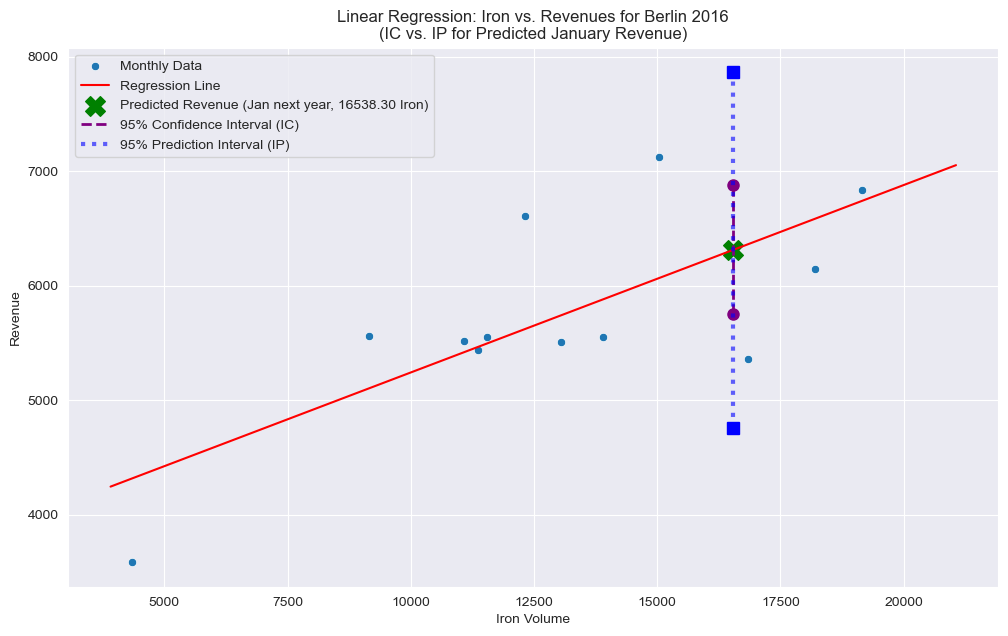

In [5]:
# Define the list of cargo columns (independent variables)
cargo_cols = ['Iron', 'Coal', 'Steel', 'Vegetables', 'Cereals', 'Wool', 'Coffee', 'Cattle', 'Mail']

def analyze_cargo_revenue_correlation(df_original_monthly, station, year):
    # Filter original monthly data for the selected station and year
    # This ensures we have 12 monthly data points (if available) for correlation and regression.
    df_filtered_monthly = df_original_monthly[
        (df_original_monthly['Station'].str.strip().str.lower() == station.lower()) &
        (df_original_monthly['Year'] == year)
        ].copy()

    if df_filtered_monthly.empty:
        print(f"No monthly data found for station '{station}' in year {year}.")
        return None, None, None, None

    # Check if there are enough data points (months) for correlation
    # Correlation requires at least two non-NaN data points for each variable.
    if len(df_filtered_monthly) < 2:
        print(f"Insufficient monthly data (only {len(df_filtered_monthly)} month(s)) for station '{station}' in year {year} to compute correlations.")
        return None, None, None, None

    correlations = {}
    for col in cargo_cols:
        # Check if both columns (cargo and revenues) have at least 2 non-NaN values for correlation calculation
        if df_filtered_monthly[col].notna().sum() >= 2 and df_filtered_monthly['Revenues'].notna().sum() >= 2:
            # Calculate Pearson correlation coefficient
            correlation_val = df_filtered_monthly[[col, 'Revenues']].corr().iloc[0, 1]
            correlations[col] = correlation_val
        else:
            correlations[col] = np.nan # Not enough valid data for correlation for this cargo type

    # Filter out NaN correlations (where correlation could not be computed) before finding the max absolute correlation
    valid_correlations = {k: v for k, v in correlations.items() if not pd.isna(v)}

    if not valid_correlations:
        print(f"No valid correlations could be computed for station '{station}' in year {year}. Check data completeness.")
        return None, None, None, None

    results_df = pd.DataFrame(list(valid_correlations.items()), columns=['Cargo Type', 'Correlation with Revenue'])
    results_df['Absolute Correlation'] = results_df['Correlation with Revenue'].abs()

    # Find the cargo type with the highest *positive* correlation
    best_positive_cargo_type = None
    max_positive_correlation_value = None
    positive_correlations_df = results_df[results_df['Correlation with Revenue'] > 0]
    if not positive_correlations_df.empty:
        best_positive_cargo_row = positive_correlations_df.loc[positive_correlations_df['Correlation with Revenue'].idxmax()]
        best_positive_cargo_type = best_positive_cargo_row['Cargo Type']
        max_positive_correlation_value = best_positive_cargo_row['Correlation with Revenue']
    else:

        pass

    print(f"\n--- Correlation Analysis for '{station}' in {year} ---")
    print("Correlation between each cargo type and Revenue (monthly data):")
    print(results_df[['Cargo Type', 'Correlation with Revenue', 'Absolute Correlation']].sort_values(by='Absolute Correlation', ascending=False).to_markdown(index=False, numalign="left", stralign="left"))
    print(f"\nThe cargo type with the highest positive correlation with Revenue is '{best_positive_cargo_type}' (Correlation: {max_positive_correlation_value:.3f}).")


    # Return the best positive cargo type and its correlation value
    return best_positive_cargo_type, max_positive_correlation_value, results_df, df_filtered_monthly

# --- Start of the main script execution ---
stations_df = pd.read_csv("Stations_Data.csv", delimiter=";", decimal=",", encoding="utf-8")

# Convert relevant columns to numeric, replacing decimal commas with points (re-doing for completeness)
cargo_cols_raw = ['Iron', 'Coal', 'Steel', 'Vegetables', 'Cereals', 'Wool', 'Coffee', 'Cattle', 'Mail']
financial_cols_raw = ['Revenues', 'Expenses']
numeric_cols_to_convert_main = cargo_cols_raw + financial_cols_raw

for col in numeric_cols_to_convert_main:
    stations_df[col] = stations_df[col].astype(str).str.replace(',', '.', regex=False)
    stations_df[col] = pd.to_numeric(stations_df[col], errors='coerce')


# Get user input for station and year
station_to_analyze = input('Enter the station (city) name: ').strip()
year_to_analyze = int(input('Enter the year to analyze: ').strip())


# Perform the correlation analysis using the `analyze_cargo_revenue_correlation` function
best_cargo, max_corr, all_correlations_df, filtered_monthly_data = \
    analyze_cargo_revenue_correlation(stations_df, station_to_analyze, year_to_analyze)

# Interpret the correlation strength
if best_cargo:
    print("\n--- Based on 'Pearson's sample correlation coefficient and coefficient of determination': ---")
    print(f"The correlation coefficient '{best_cargo}' of {max_corr:.3f} indicates the strength and direction of the linear relationship with Revenue.")
    if abs(max_corr) >= 0.8:
        print("This indicates a strong linear association.")
    elif abs(max_corr) >= 0.5:
        print("This indicates a moderate linear association.")
    elif abs(max_corr) >= 0.1:
        print("This indicates a weak linear association.")
    else:
        print("This indicates a slight or zero linear association.")

# --- Define the function for linear regression  ---
def perform_linear_regression(df_monthly_filtered, independent_var, dependent_var='Revenues'):

    X = df_monthly_filtered[independent_var]
    Y = df_monthly_filtered[dependent_var]

    slope, intercept, r_value, p_value, stderr = stats.linregress(X, Y)
    y_hat = intercept + slope * X
    sqe = np.sum((Y - y_hat)**2)
    n = len(df_monthly_filtered)
    s_squared = sqe / (n - 2) if (n - 2) > 0 else np.nan

    print(f"\n--- Simple Linear Regression Model ({independent_var} vs. {dependent_var}) ---")
    print(f"Regression Line: Revenues = {intercept:.3f} + {slope:.3f} * {independent_var}")
    print(f"R-squared (Coefficient of Determination): {r_value**2:.3f}")
    print(f"P-value of slope: {p_value:.3f} (Significance of {independent_var})")
    print(f"Standard Error of Slope: {stderr:.3f}")
    print(f"Sum of Squared Errors (SQE): {sqe:.3f}")
    print(f"Estimated Variance of Residuals (s^2 / MSE): {s_squared:.3f}")

    model_results = {
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'p_value': p_value,
        'stderr': stderr,
        's_squared': s_squared,
        'sqe': sqe, # ADDED LINE
        'n': n,
        'S_xx': np.sum((X - np.mean(X))**2)
    }
    return model_results

# --- Prediction and Confidence/Prediction Interval Function Definition (UPDATED) ---
def predict_and_confidence_interval(model_results, df_monthly_filtered, independent_var, dependent_var,
                                    predicted_cargo_increase_percent=0.10, confidence_level=0.95,
                                    override_jan_cargo=None): # Added override parameter

    # Extract model parameters
    slope = model_results['slope']
    intercept = model_results['intercept']
    s_squared = model_results['s_squared']
    n = model_results['n']
    S_xx = model_results['S_xx']
    x_mean = df_monthly_filtered[independent_var].mean()

    # Determine January's current year cargo value
    if override_jan_cargo is not None:
        current_jan_cargo = override_jan_cargo
    else:
        january_data = df_monthly_filtered[df_monthly_filtered['Month'] == 1]
        if january_data.empty:
            print(f"No January data found for {independent_var} in the current year.")
            return None, None, None, None, None, None
        current_jan_cargo = january_data[independent_var].iloc[0]

    # Calculate the predicted cargo amount for January of the following year
    predicted_cargo_amount = current_jan_cargo * (1 + predicted_cargo_increase_percent)

    # Predict the revenue (y_hat_p) for the new cargo amount
    y_hat_p = intercept + slope * predicted_cargo_amount

    # Calculate the t-score for the given confidence level
    alpha = 1 - confidence_level
    t_critical = stats.t.ppf(1 - alpha / 2, df=n - 2)

    # --- Confidence Interval for the Mean Response (IC)  ---
    se_mean_response = np.sqrt(s_squared * (1/n + (predicted_cargo_amount - x_mean)**2 / S_xx))
    margin_of_error_ic = t_critical * se_mean_response
    ic_lower_bound = y_hat_p - margin_of_error_ic
    ic_upper_bound = y_hat_p + margin_of_error_ic

    # --- Prediction Interval for a New Observation (IP)  ---
    se_prediction_interval = np.sqrt(s_squared * (1 + 1/n + (predicted_cargo_amount - x_mean)**2 / S_xx))
    margin_of_error_ip = t_critical * se_prediction_interval
    ip_lower_bound = y_hat_p - margin_of_error_ip
    ip_upper_bound = y_hat_p + margin_of_error_ip

    print(f"\n--- Revenue Prediction and {confidence_level*100:.0f}% Intervals ---")
    print(f"January's current year ({station_to_analyze} {year_to_analyze}) {independent_var} cargo: {current_jan_cargo:.2f}")
    print(f"Predicted {independent_var} cargo (10% increase for Jan next year): {predicted_cargo_amount:.2f}")
    print(f"Expected Revenue for predicted cargo: {y_hat_p:.2f}")

    print(f"\n95% Confidence Interval for Expected Revenue (IC): [{ic_lower_bound:.2f}, {ic_upper_bound:.2f}]\n  Margin of Error (IC): {margin_of_error_ic:.2f}\n  T-critical ({confidence_level*100:.0f}% confidence, {n-2} df): {t_critical:.3f}\n  Mean of X ({independent_var}): {x_mean:.2f}")

    print(f"\n95% Prediction Interval for New Observation (IP): [{ip_lower_bound:.2f}, {ip_upper_bound:.2f}]\n  Margin of Error (IP): {margin_of_error_ip:.2f}")

    # Interpretation based on Chapter 4 & 6
    print("\nInterpretation of Confidence and Prediction Intervals:")
    print(f"The {confidence_level*100:.0f}% Confidence Interval (IC) of [{ic_lower_bound:.2f}, {ic_upper_bound:.2f}] estimates the true *average* revenue for all instances where cargo is {predicted_cargo_amount:.2f}.")
    print(f"The {confidence_level*100:.0f}% Prediction Interval (IP) of [{ip_lower_bound:.2f}, {ip_upper_bound:.2f}] estimates the range for a *single new individual* revenue observation when cargo is {predicted_cargo_amount:.2f}.")
    print(f"Note that the Prediction Interval is wider, reflecting greater uncertainty for an individual prediction compared to an average prediction.")



    return y_hat_p, ic_lower_bound, ic_upper_bound, ip_lower_bound, ip_upper_bound, predicted_cargo_amount

# --- Plotting Function Definition (UPDATED to potentially show IP) ---
# Python
def plot_regression(df_monthly_filtered, independent_var, dependent_var, model_results,
                    predicted_cargo_amount, predicted_revenue, ci_lower, ci_upper,
                    ip_lower, ip_upper, # New parameters for IP bounds
                    station_name, year_num):

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(12, 7))
    sns.scatterplot(x=df_monthly_filtered[independent_var], y=df_monthly_filtered[dependent_var], label='Monthly Data')

    # Plot regression line
    min_x = df_monthly_filtered[independent_var].min()
    max_x = df_monthly_filtered[independent_var].max()  # <-- Fixed here
    plot_min_x = min(min_x * 0.9, predicted_cargo_amount * 0.9 if predicted_cargo_amount is not None else min_x * 0.9)
    plot_max_x = max(max_x * 1.1, predicted_cargo_amount * 1.1 if predicted_cargo_amount is not None else max_x * 1.1)

    X_for_line = np.linspace(plot_min_x, plot_max_x, 100)
    Y_line = model_results['intercept'] + model_results['slope'] * X_for_line
    plt.plot(X_for_line, Y_line, color='red', label='Regression Line')

    # Plot predicted point if available
    if predicted_revenue is not None and predicted_cargo_amount is not None:
        plt.scatter(predicted_cargo_amount, predicted_revenue, color='green', marker='X', s=200,
                    label=f'Predicted Revenue (Jan next year, {predicted_cargo_amount:.2f} {independent_var})')

        # Plot Confidence Interval (IC) for the predicted point
        plt.vlines(predicted_cargo_amount, ci_lower, ci_upper, colors='purple', linestyles='dashed', lw=2,
                   label='95% Confidence Interval (IC)')
        plt.plot(predicted_cargo_amount, ci_lower, 'o', color='purple', markersize=8)
        plt.plot(predicted_cargo_amount, ci_upper, 'o', color='purple', markersize=8)

        # Plot Prediction Interval (IP) for the predicted point
        plt.vlines(predicted_cargo_amount, ip_lower, ip_upper, colors='blue', linestyles='dotted', lw=3, alpha=0.6,
                   label='95% Prediction Interval (IP)')
        plt.plot(predicted_cargo_amount, ip_lower, 's', color='blue', markersize=8)
        plt.plot(predicted_cargo_amount, ip_upper, 's', color='blue', markersize=8)

    plt.title(f'Linear Regression: {independent_var} vs. {dependent_var} for {station_name} {year_num}\n(IC vs. IP for Predicted January Revenue)')
    plt.xlabel(f'{independent_var} Volume')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Integration with main script logic ---
if best_cargo and filtered_monthly_data is not None and len(filtered_monthly_data) > 2:
    # 1. Perform Linear Regression
    model_results = perform_linear_regression(filtered_monthly_data, best_cargo)

    # 2. Predict Revenue and calculate Confidence and Prediction Intervals

    # PROMPT HERE:
    override_jan_cargo_input = input(
        f"Enter January's current year ({year_to_analyze}) {best_cargo} cargo amount (press Enter to use actual data if available, or type a number to override): "
    ).strip()

    if override_jan_cargo_input:
        try:
            # Convert user input to float if provided
            jan_cargo_for_prediction = float(override_jan_cargo_input)
        except ValueError:
            print("Invalid input for January cargo amount. Using actual data if available.")
            jan_cargo_for_prediction = None # Fallback to actual data in predict function
    else:
        jan_cargo_for_prediction = None # User pressed Enter, use actual data


    if not np.isnan(model_results['s_squared']) and model_results['n'] > 2:
        predicted_revenue, ic_lower, ic_upper, ip_lower, ip_upper, predicted_cargo_amount_for_plot = \
            predict_and_confidence_interval(model_results, filtered_monthly_data, best_cargo, 'Revenues',
                                            override_jan_cargo=jan_cargo_for_prediction) # Pass the user's input or None

        # 3. Visualize the regression if prediction was successful
        if predicted_revenue is not None:
            plot_regression(filtered_monthly_data, best_cargo, 'Revenues', model_results,
                            predicted_cargo_amount_for_plot, predicted_revenue, ic_lower, ic_upper,
                            ip_lower, ip_upper,
                            station_to_analyze, year_to_analyze)
        else:
            print("Skipping visualization because prediction failed.")
    else:
        print("Skipping prediction and visualization: Not enough data or invalid model results for CI calculation.")
else:
    print("Skipping linear regression, prediction, and visualization due to insufficient data or previous errors in correlation analysis.")

#### Implemented by: Yasamin Ebrahimi
#### Contribution: 100%